<a href="https://colab.research.google.com/github/KeyMoney22/Plant_disease_classification-/blob/main/tomato_disease_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
import os
from PIL import Image
from tensorflow.keras import models, layers

In [2]:

# Mount Google Drive
drive.mount('/content/drive')

# Navigate to your folder
folder_path = '/content/drive/MyDrive/PlantVillage'




Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
#loading the data
data= tf.keras.utils.image_dataset_from_directory(folder_path, labels='inferred', label_mode='categorical',
                                            class_names=None, color_mode='rgb', batch_size=32,
                                            image_size=(256, 256), shuffle=True, seed=None,
                                            validation_split=None, subset=None, interpolation='bilinear',
                                            follow_links=False, crop_to_aspect_ratio=False)

Found 16031 files belonging to 10 classes.


In [4]:
len(data)

501

In [5]:
for image_batch, label_batch in data:
  print(image_batch.shape)
  print(label_batch.shape)
  break
  #3 = rgb
  #32 = batch size
  # 256, 256= height , weight

(32, 256, 256, 3)
(32, 10)


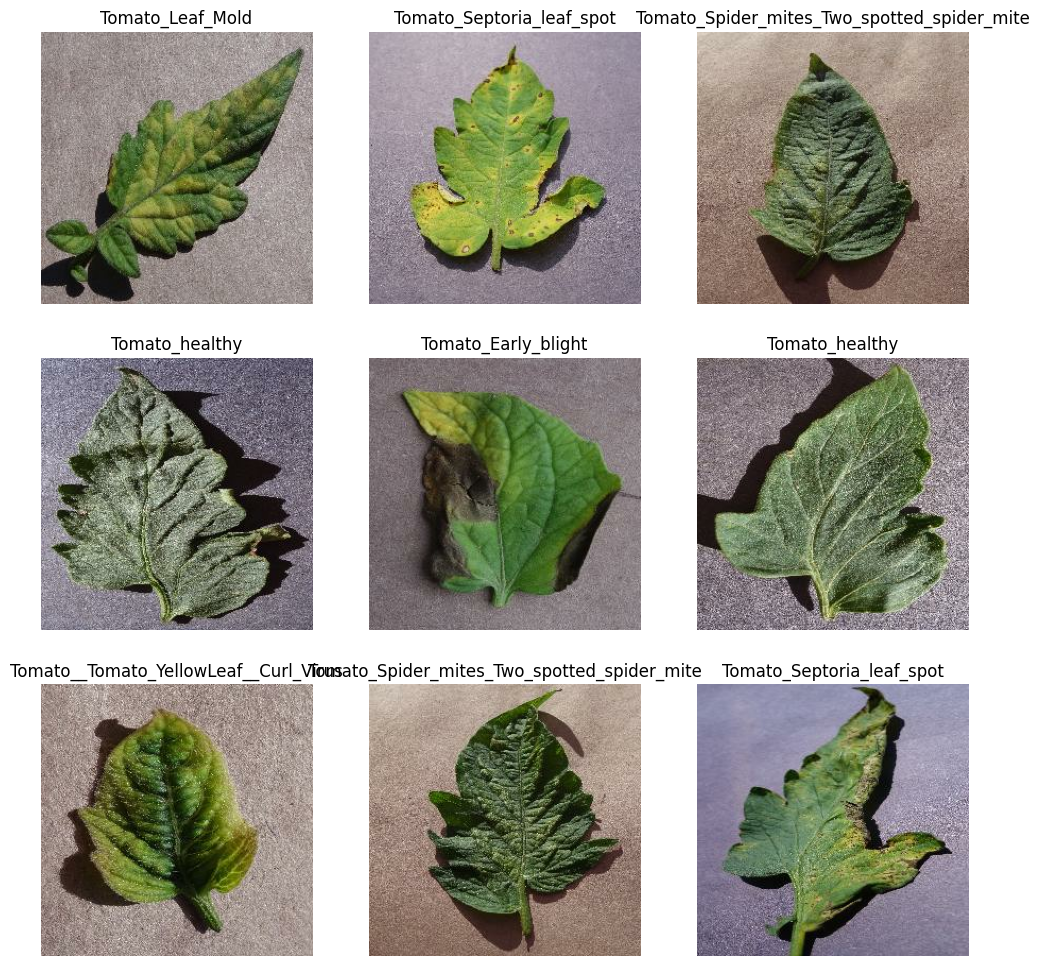

In [6]:


def preview_data(dataset, class_names, num_images=9):
    plt.figure(figsize=(12, 12))
    for images, labels in dataset.take(1):
        for i in range(num_images):
            ax = plt.subplot(3, 3, i + 1)
            plt.imshow(images[i].numpy().astype("uint8"))
            plt.title(class_names[tf.argmax(labels[i])])
            plt.axis("off")#hide the numbers
    plt.show()

class_names = data.class_names
preview_data(data, class_names)


In [7]:
class_names


['Tomato_Bacterial_spot',
 'Tomato_Early_blight',
 'Tomato_Late_blight',
 'Tomato_Leaf_Mold',
 'Tomato_Septoria_leaf_spot',
 'Tomato_Spider_mites_Two_spotted_spider_mite',
 'Tomato__Target_Spot',
 'Tomato__Tomato_YellowLeaf__Curl_Virus',
 'Tomato__Tomato_mosaic_virus',
 'Tomato_healthy']

In [8]:
def clean_class_name(name):
    name = name.replace('__', '_')
    name = name.replace('__', '_')
    if name == 'Tomato_Spider_mites_Two_spotted_spider_mite':
        name = 'Tomato_Spider_mites'
    elif name == 'Tomato_Tomato_YellowLeaf_Curl_Virus':
        name = 'Tomato_Yellow_Leaf_Curl_Virus'
    elif name == 'Tomato_Tomato_mosaic_virus':
        name = 'Tomato_Mosaic_Virus'
    name = name.lower()
    return name

class_names = [clean_class_name(name) for name in class_names] # Use a different variable name here
class_names # Print the cleaned class names

['tomato_bacterial_spot',
 'tomato_early_blight',
 'tomato_late_blight',
 'tomato_leaf_mold',
 'tomato_septoria_leaf_spot',
 'tomato_spider_mites',
 'tomato_target_spot',
 'tomato_yellow_leaf_curl_virus',
 'tomato_mosaic_virus',
 'tomato_healthy']

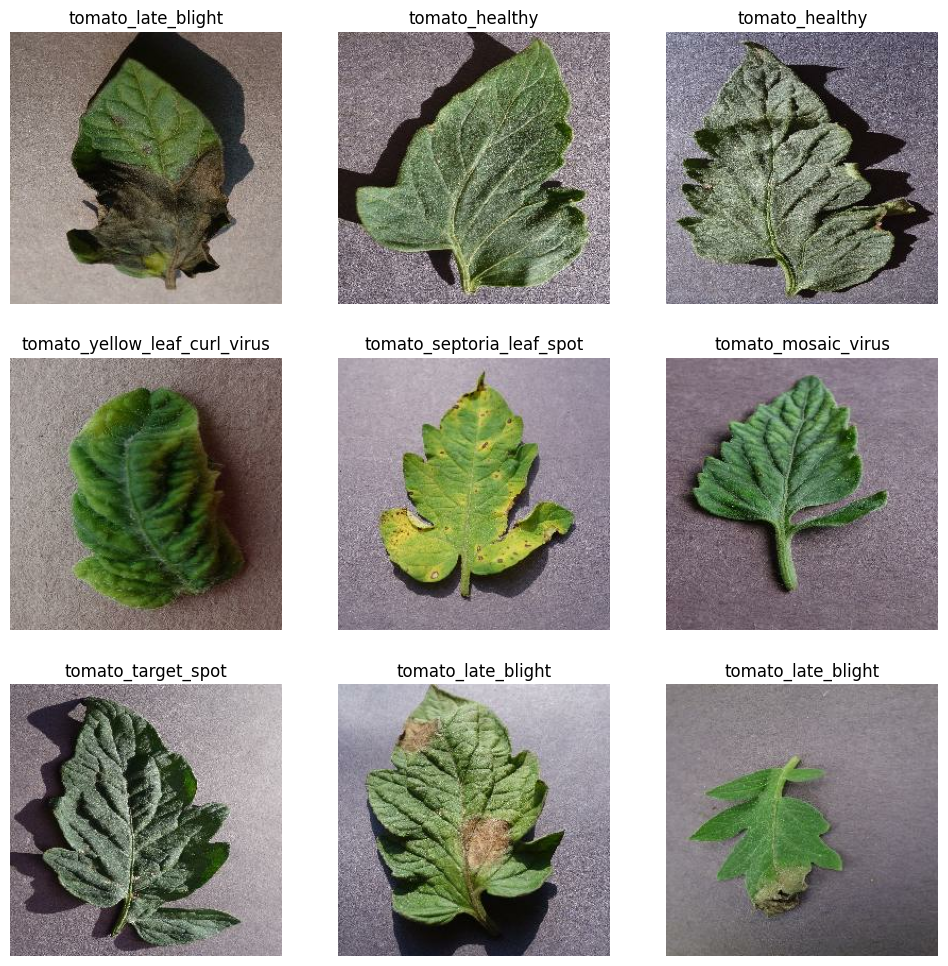

In [9]:
preview_data(data, class_names)

In [10]:
def check_corrupt_images(folder_path):
    corrupt_images = []
    for root, _, files in os.walk(folder_path):
        for file in files:
            try:
                img = Image.open(os.path.join(root, file))
                img.verify()  # Verify that it is, in fact, an image
            except (IOError, SyntaxError) as e:
                corrupt_images.append(os.path.join(root, file))
    return corrupt_images

corrupt_images = check_corrupt_images(folder_path)
print(f"Found {len(corrupt_images)} corrupt images.")

Found 1 corrupt images.


In [11]:
# for img_path in corrupt_images:
#     try:
#       os.remove(img_path)
#       print("Corrupt image removed:{img_path}")
#     except OSError:
#       pass

Class distribution: {'tomato_target_spot': 1404, 'tomato_healthy': 1601, 'tomato_bacterial_spot': 2127, 'tomato_yellow_leaf_curl_virus': 3208, 'tomato_late_blight': 1919, 'tomato_spider_mites': 1676, 'tomato_early_blight': 1000, 'tomato_leaf_mold': 952, 'tomato_septoria_leaf_spot': 1771, 'tomato_mosaic_virus': 373}


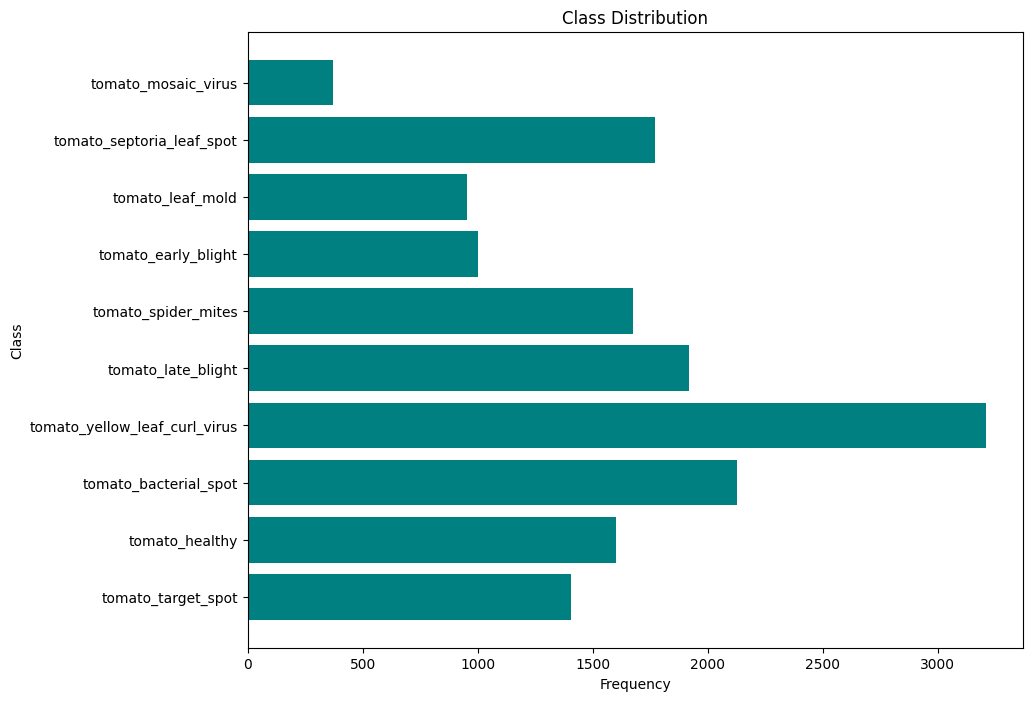

In [12]:
# Define the function to check class distribution
def check_class_distribution(dataset):
    class_counts = {}
    for images, labels in dataset:
        for label in labels:
            class_name = class_names[tf.argmax(label)]
            if class_name in class_counts:
                class_counts[class_name] += 1
            else:
                class_counts[class_name] = 1
    return class_counts

# Check class distribution
class_distribution = check_class_distribution(data)
print("Class distribution:", class_distribution)

# Visualize class distribution with a horizontal bar chart
plt.figure(figsize=(10, 8))
plt.barh(list(class_distribution.keys()), list(class_distribution.values()), color='Teal')
plt.title('Class Distribution')
plt.xlabel('Frequency')
plt.ylabel('Class')
plt.show()

In [17]:
def split_data(data, train_split = 0.8, val_split = 0.1, test_split = 0.1, shuffle=True, shuffle_size=10000):
  data_size = len(data)
  if shuffle:
    data = data.shuffle(shuffle_size)
  train_size = int(train_split* len(data))
  val_size = int(val_split*len(data))

  train_set = data.take(train_size)

  val_set = data.skip(train_size).take(val_size)
  test_set = data.skip(train_size).skip(val_size)
  return train_set, val_set, test_set


In [18]:
train_set, val_set, test_set = split_data(data)
print(len(train_set))
print(len(val_set))
print(len(test_set))

400
50
51


In [19]:
train_set = train_set.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_set = val_set.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_set = test_set.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [20]:
tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(256,256),
    layers.experimental.preprocessing.Rescaling(1.0/255),
])

In [ ]:
# #Importing inception V3 for preprocessing and classification
# inception = InceptionV3(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)
# #To make all layers as false in order to use all weights
# for layer in inception.layers:
#     layer.trainable = False

#     #To get classes
#     folders = glob('tomato_disease_dataset/train/*')

In [ ]:
# # prompt: data augmentaion

# data_augmentation = tf.keras.Sequential([
#   layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
#   layers.experimental.preprocessing.RandomRotation(0.2),
# ])
